# Plot the time of saccade vs. the length of a saccade

/Users/larsrefsgaard/repos/flow/apps/backend/velocityThreshold.py:62: RuntimeWarning: invalid value encountered in scalar divide
  rho = cov[0,1] / (sx*sy)


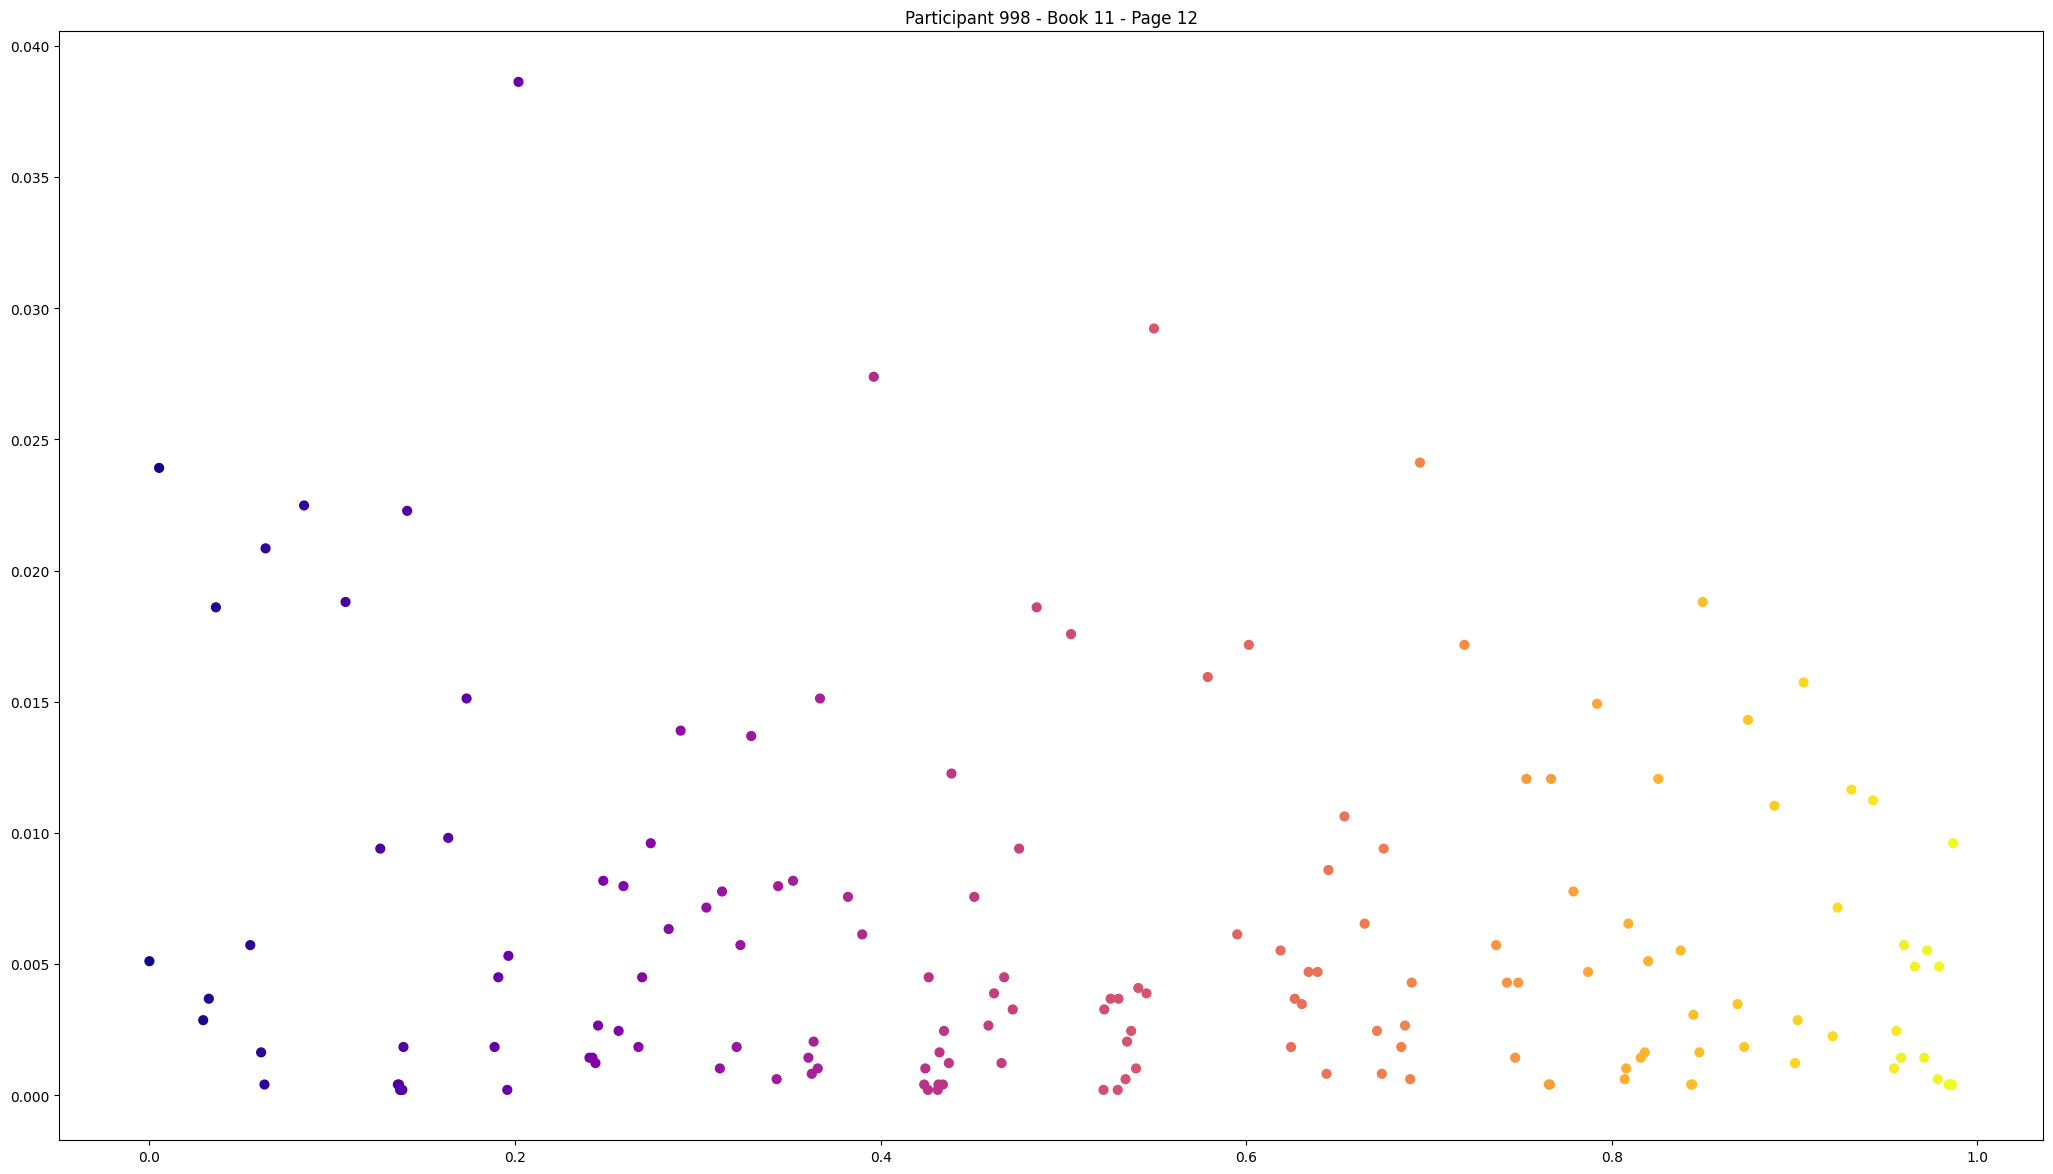

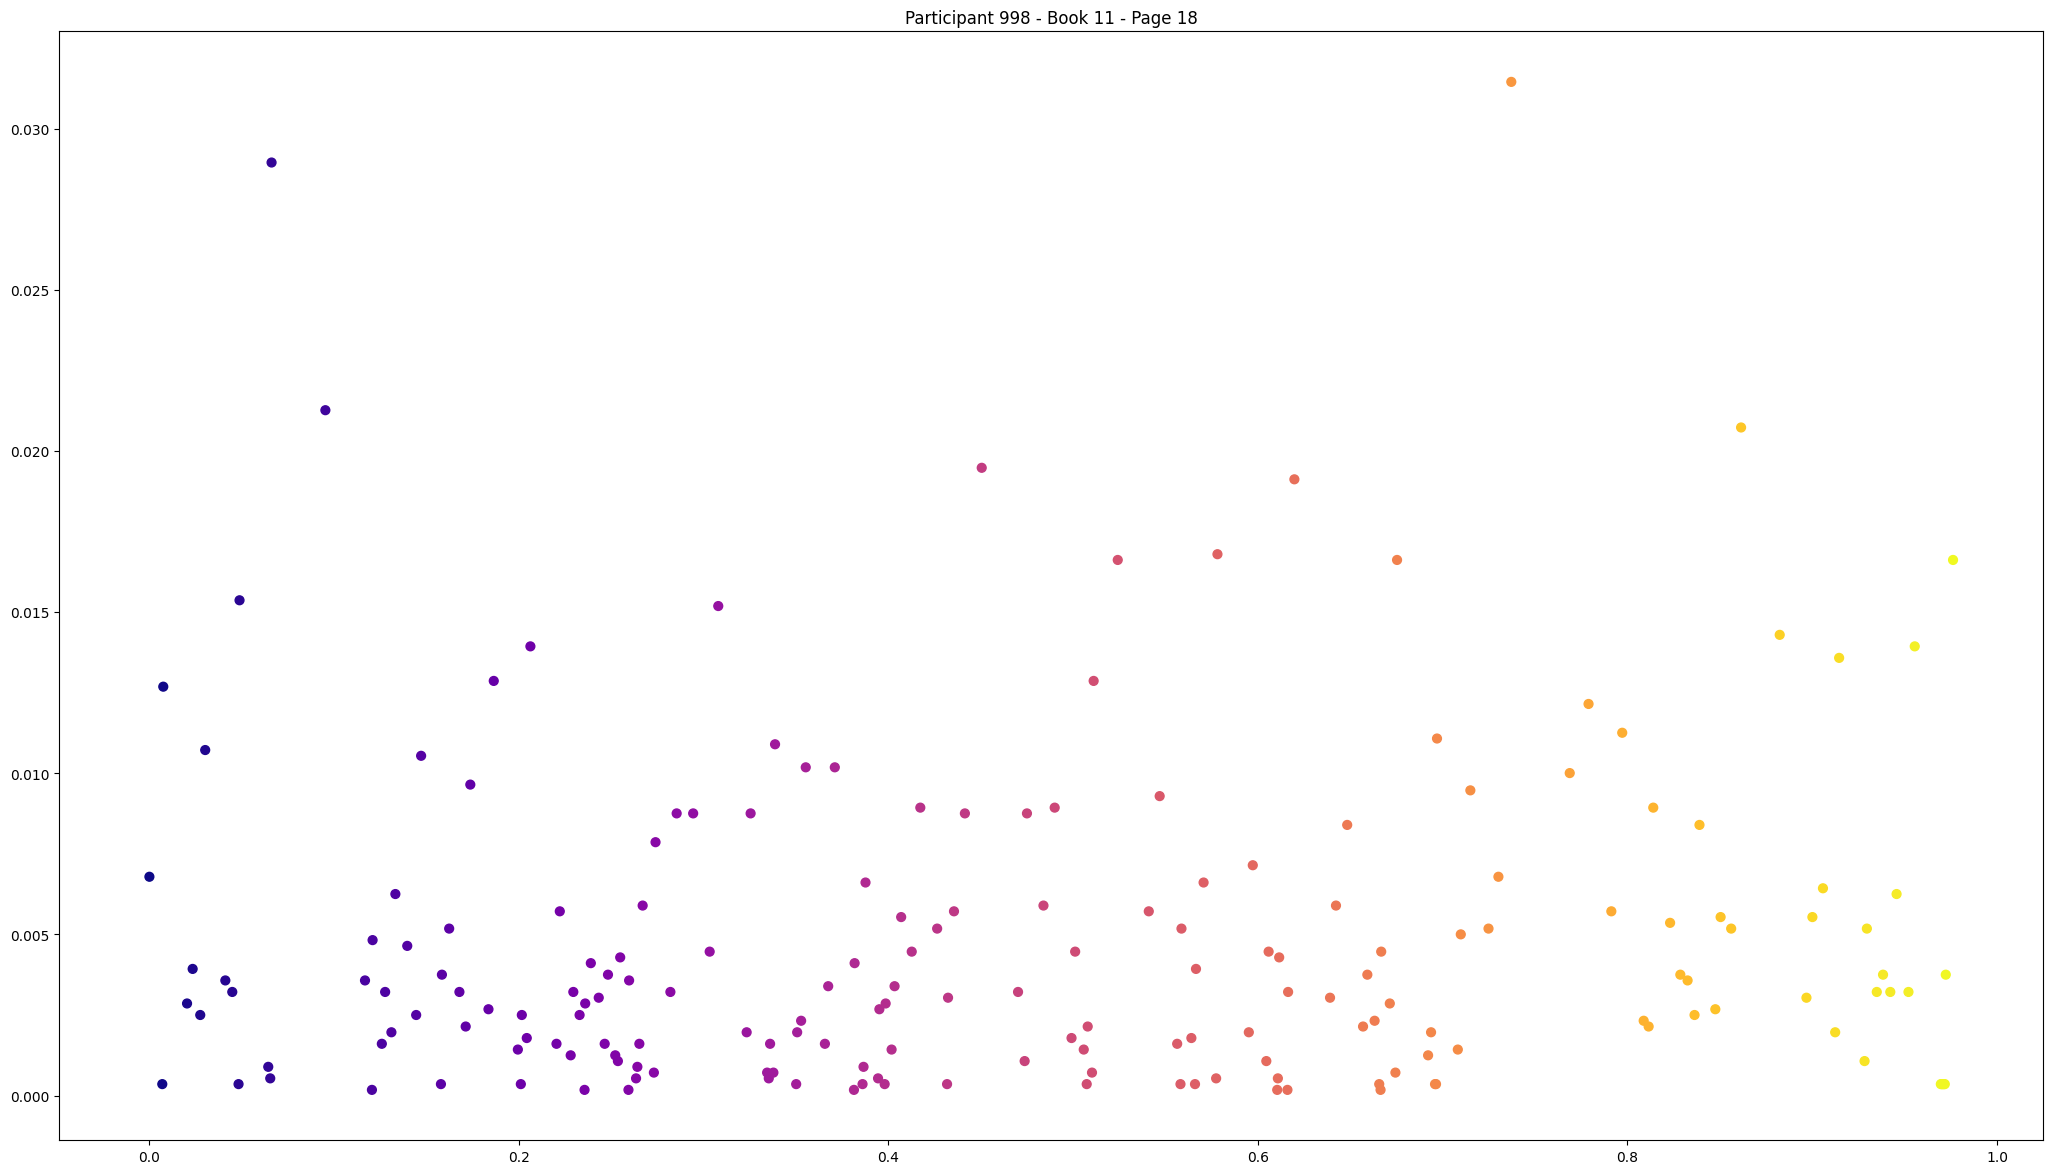

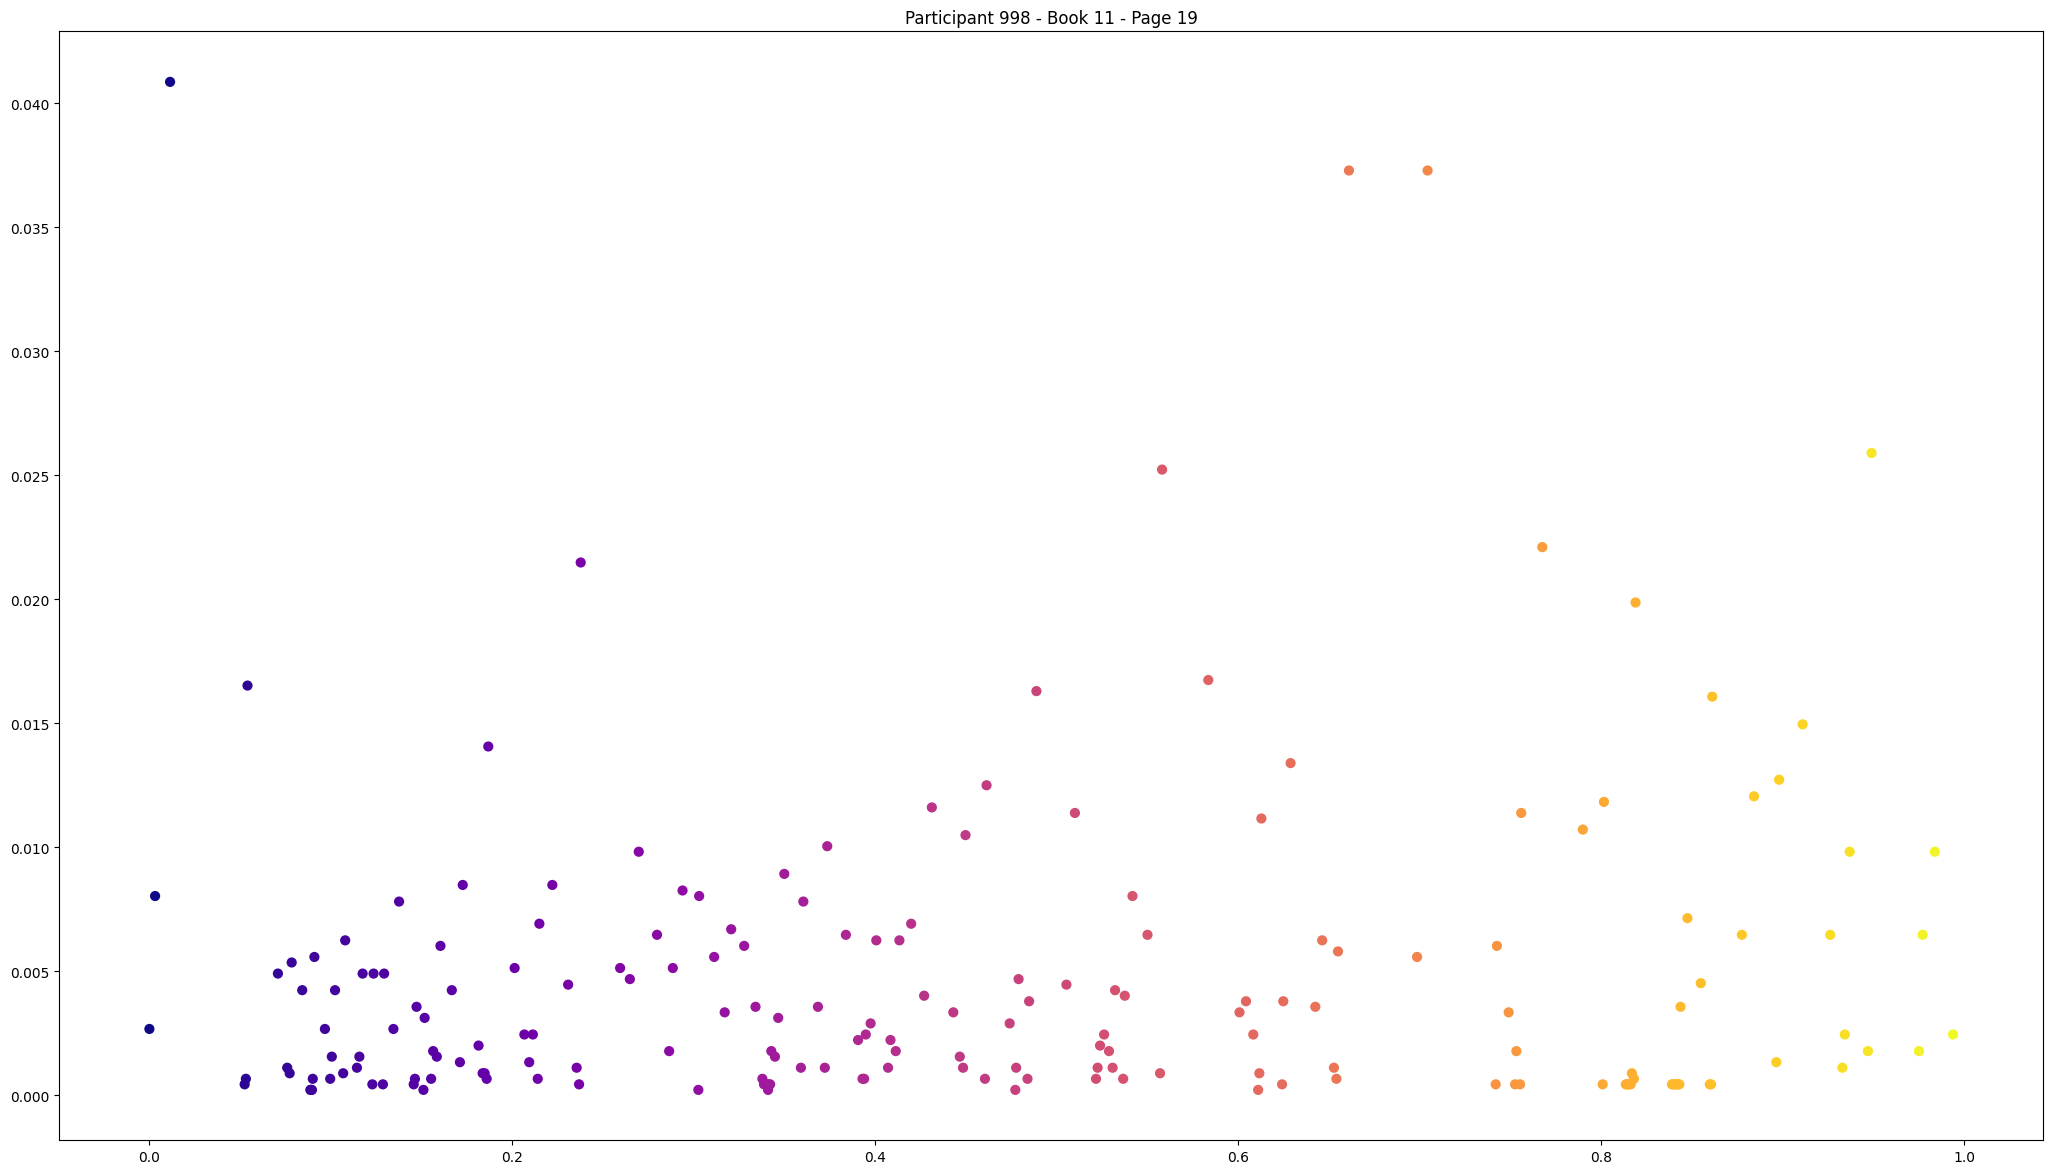

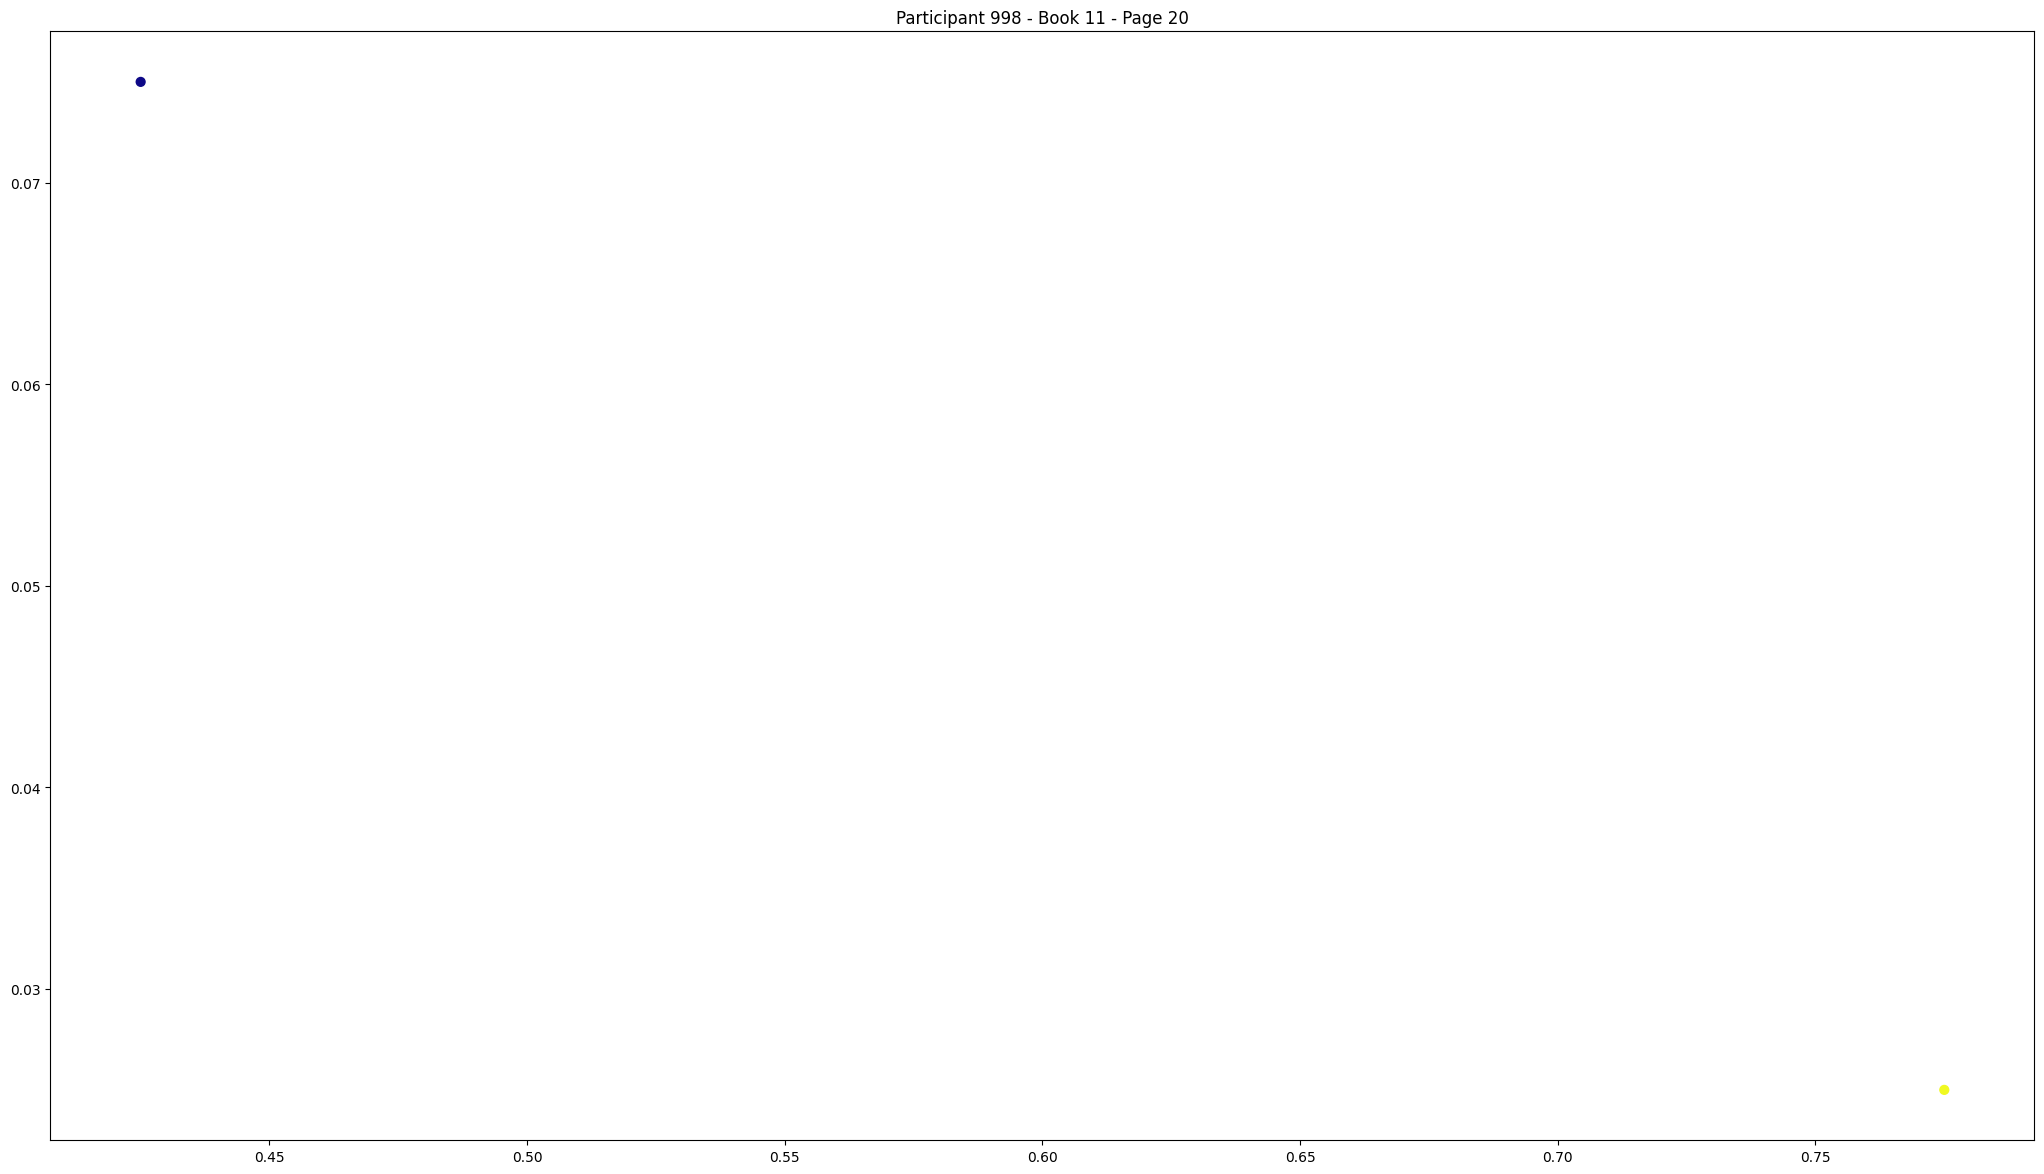

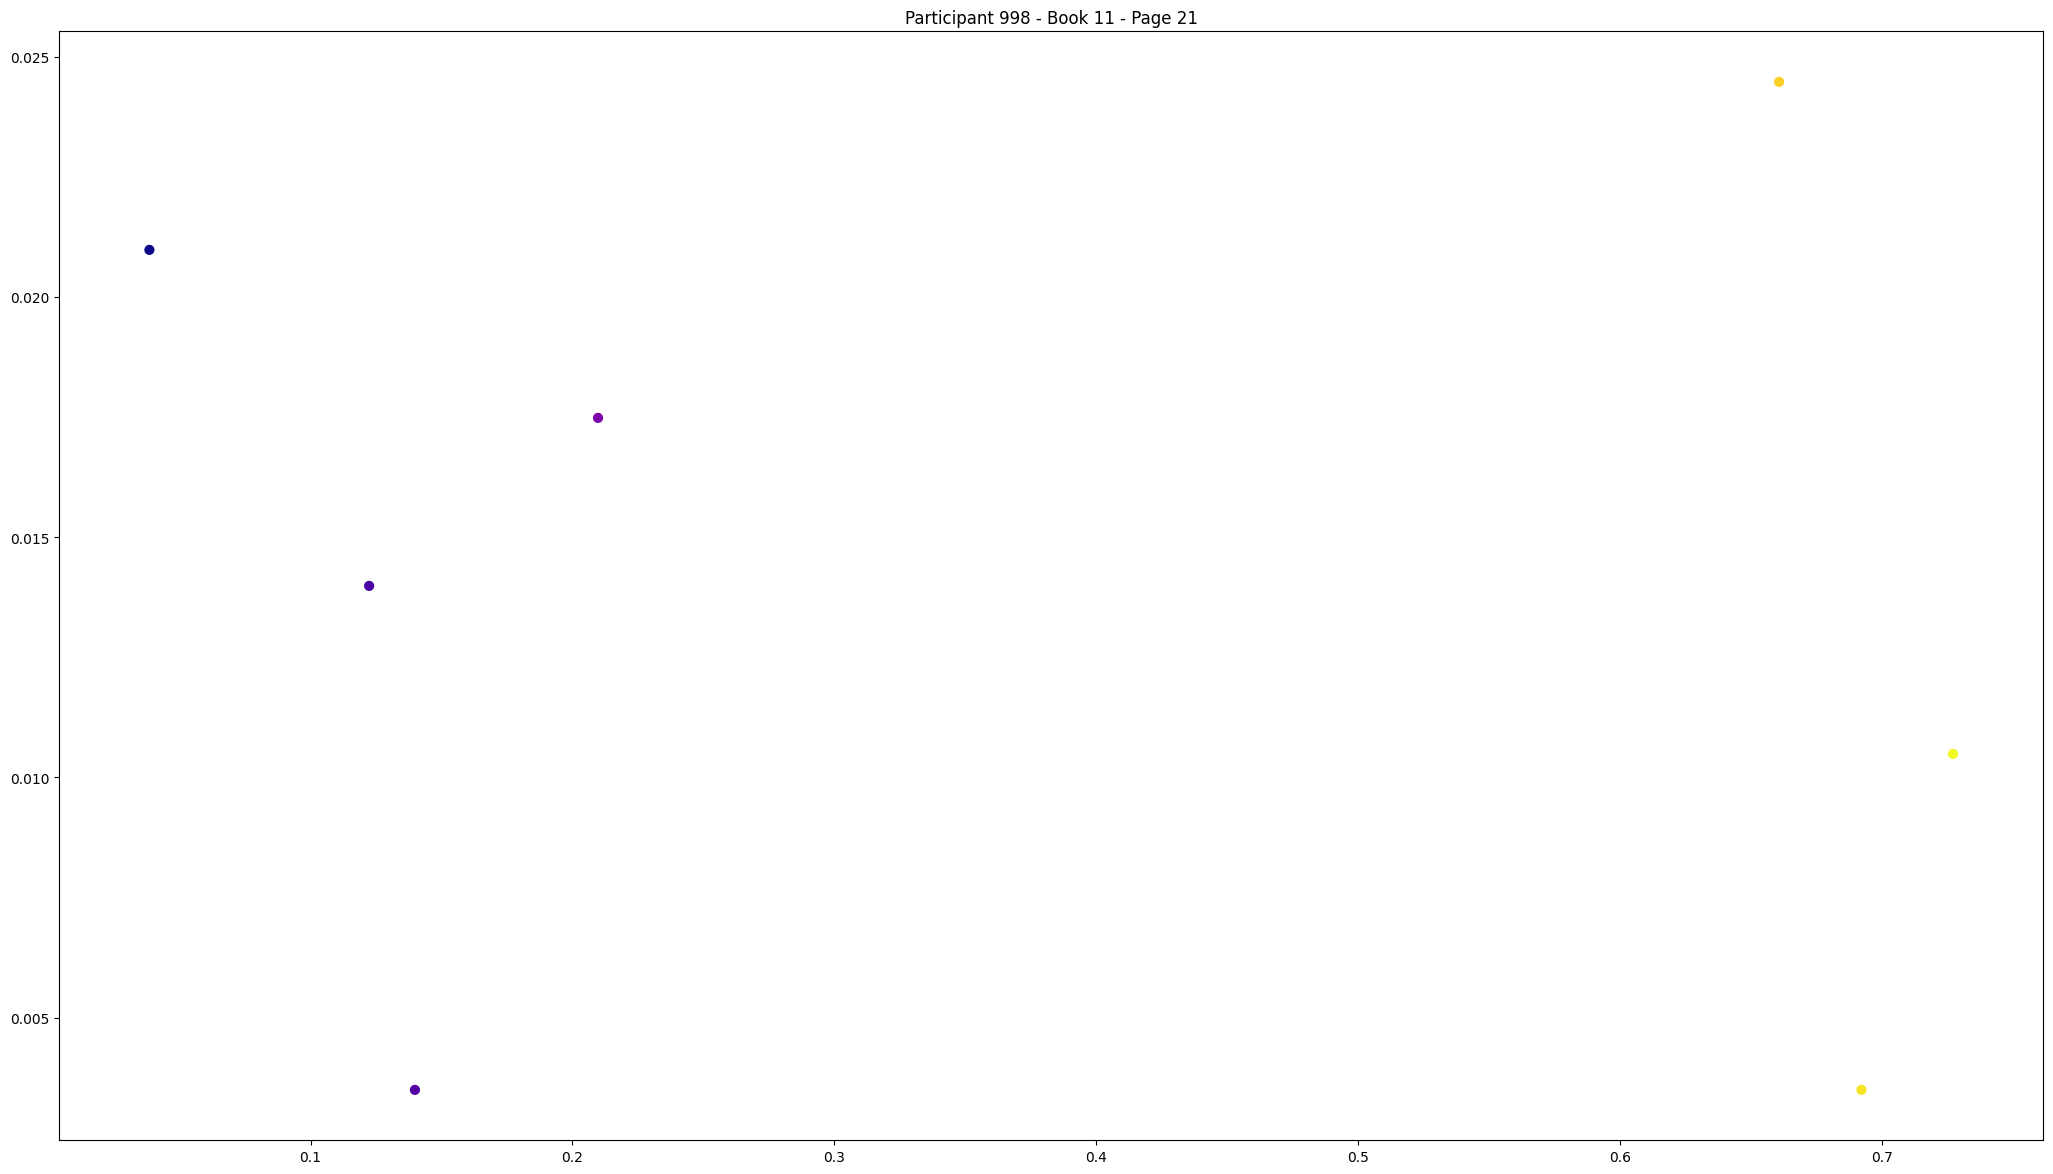

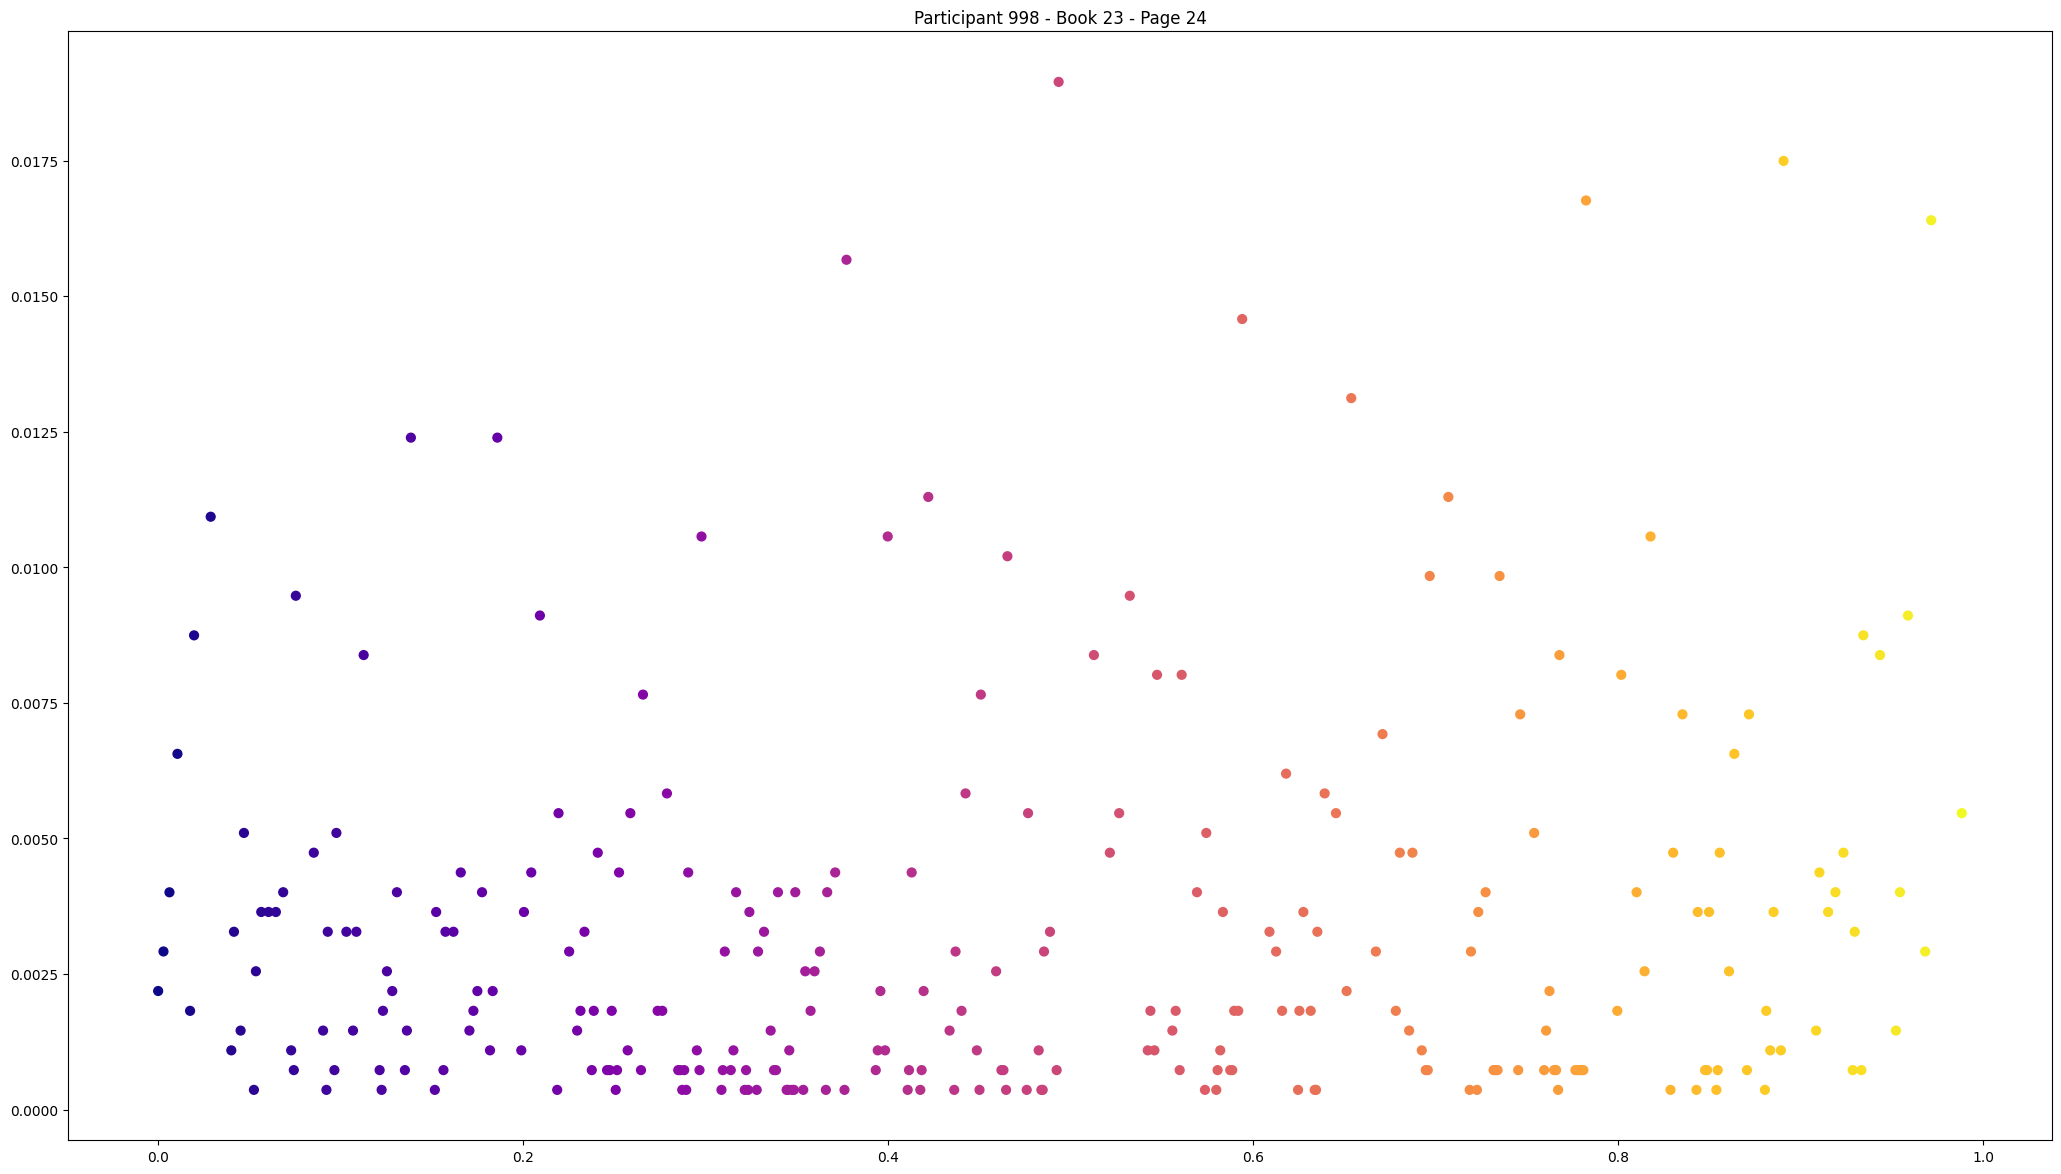

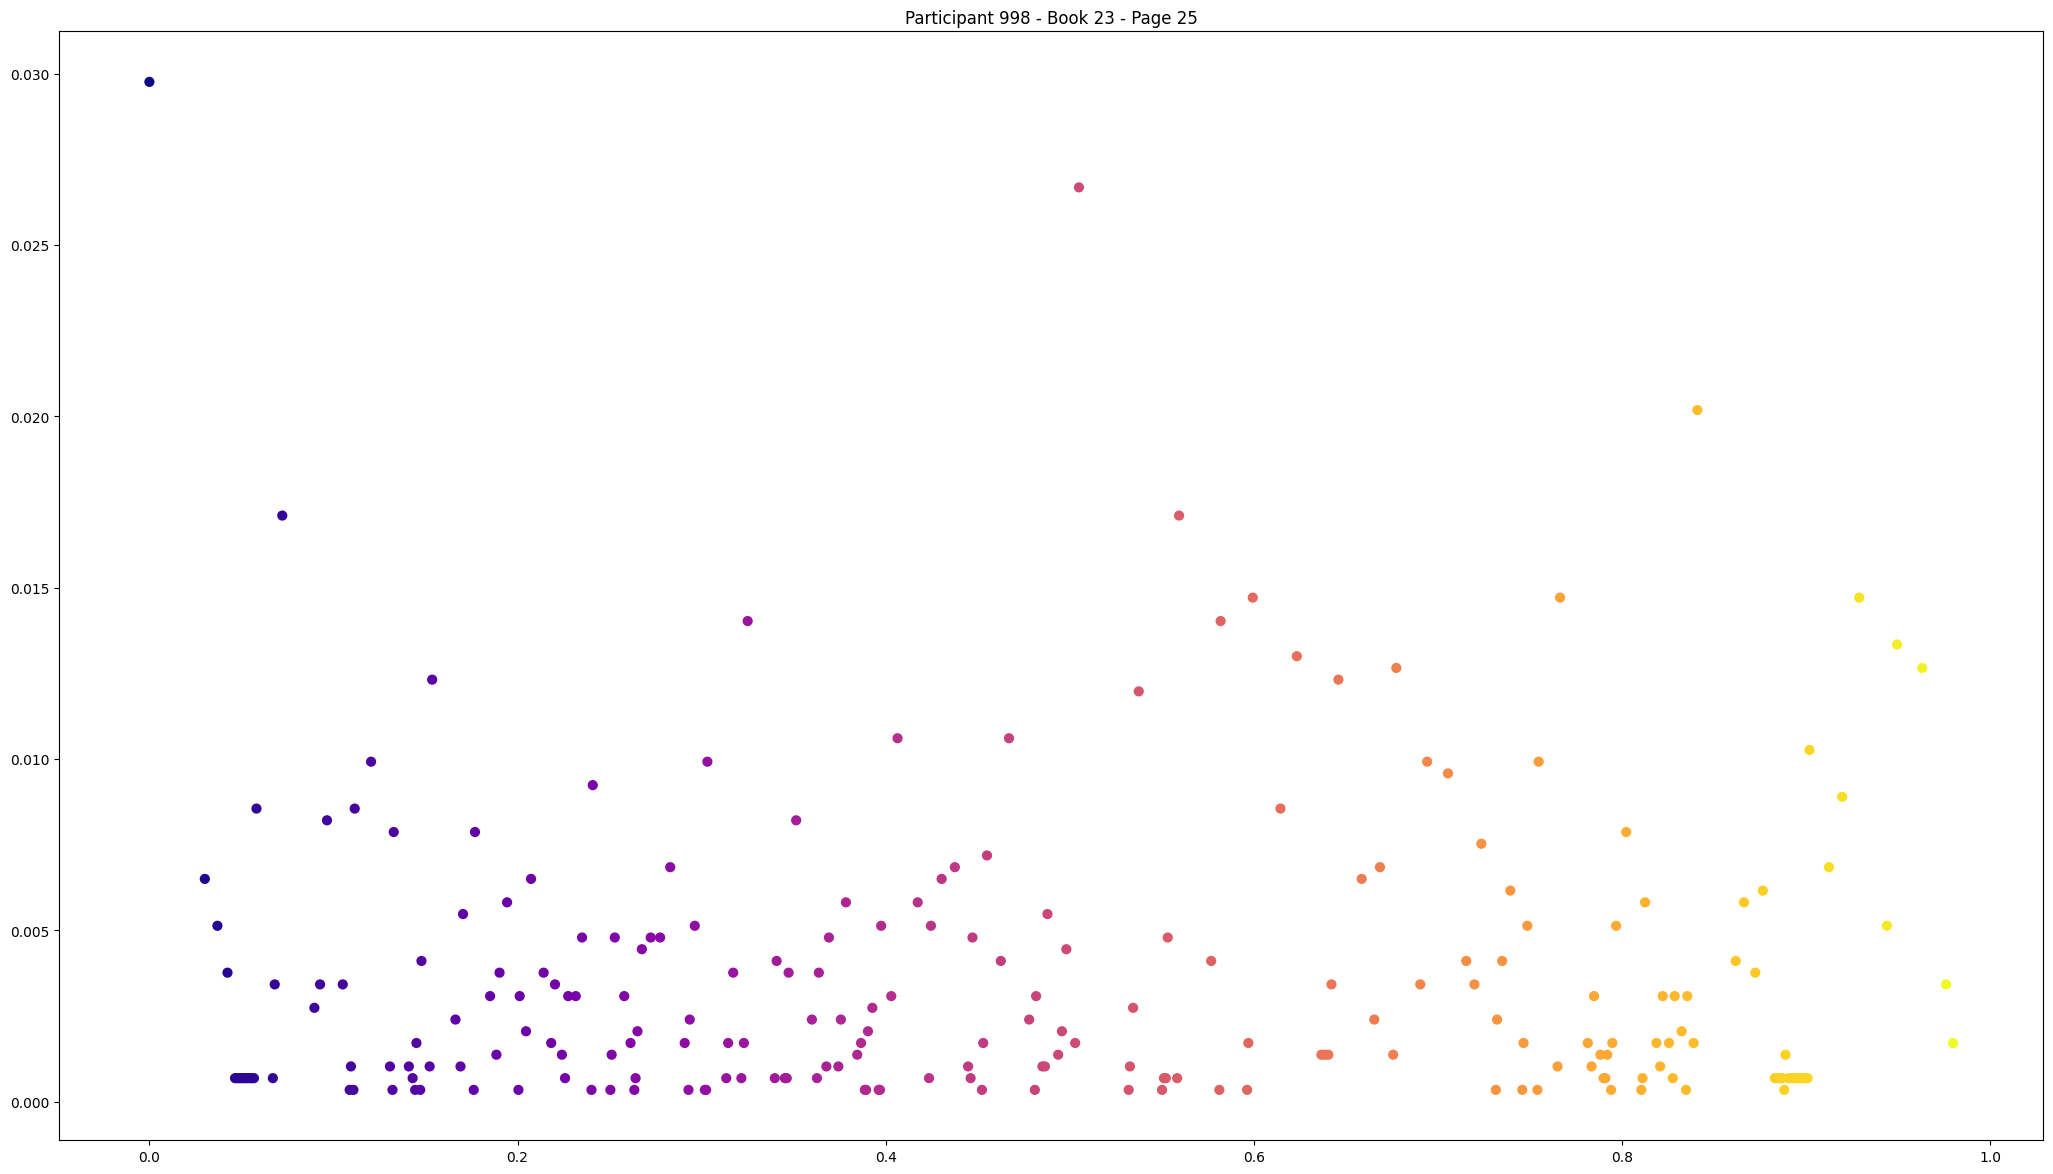

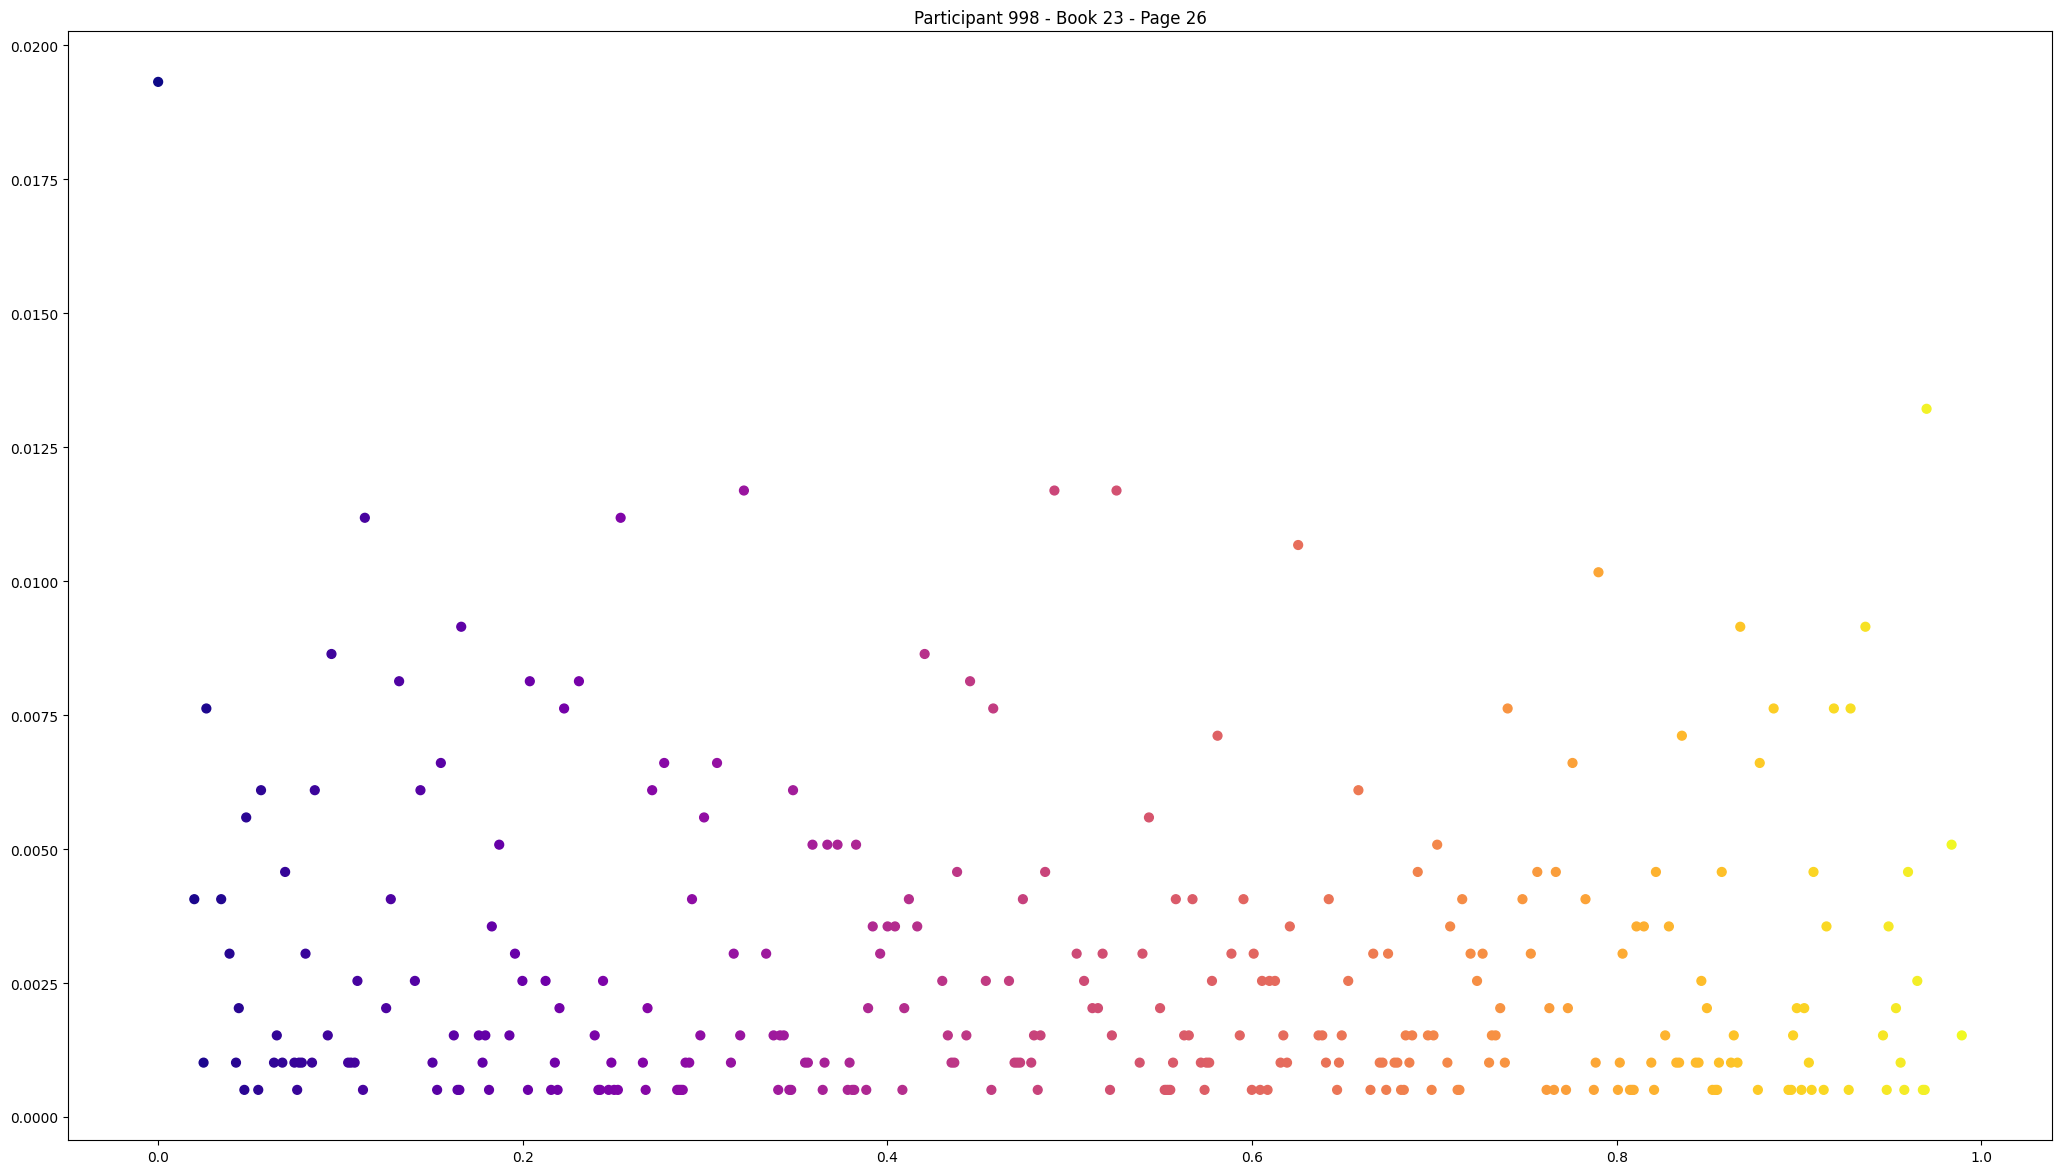

In [3]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from utils import (
    TIMESTAMP_IDENT,
    X_PIXELS,
    Y_PIXELS,
    Events,
    extract_gaze_data_between_timestamps_proper,
)
import json

from velocityThreshold import detect_fix_ivt, find_sacc_from_fix

EYE_TRACKER_FOLDER = "eye_tracker_data/"
GAZE_DATA = []
GAZE_DATA_BOOK = []
GAZE_DATA_PAGE = []

# participants that were told that they can change the settings beforehand
participant_ids = [998]
subquery = Events.select().where(Events.participant_id.in_(participant_ids))
books = subquery.where(Events.event == "OPEN_BOOK")

for participant in participant_ids:
    for book in books:
        START_TIME_BOOK = book.time
        book_end = (
            subquery.where(Events.event == "CLOSE_BOOK")
            .where(Events.time > START_TIME_BOOK)
            .get()
        )
        END_TIME_BOOK = book_end.time

        # Get the events that have a timestamp less than the first CLOSE_BOOK event
        events_book = subquery.where(Events.time <= END_TIME_BOOK)

        formatted_time = datetime.fromtimestamp(START_TIME_BOOK / 1000).strftime(
            "%Y-%m-%d_%H-%M-%S"
        )
        GAZE_FILE = f"{EYE_TRACKER_FOLDER}[{participant}]-{formatted_time}.json"
        f = open(GAZE_FILE, "r")
        GAZE_DATA_BOOK = json.load(f)
        f.close()

        pages = (
            subquery.where(Events.event == "NEXT_PAGE")
            .where(Events.time > START_TIME_BOOK)
            .where(Events.time < END_TIME_BOOK)
        )
        for page in pages:
            START_TIME_PAGE = page.time
            end_page = (
                subquery.where(Events.event == "NEXT_PAGE").where(
                    Events.time > START_TIME_PAGE
                )
            )
            if end_page.count() == 0:
                continue
            END_TIME_PAGE = (end_page.get()).time

            # Get the gaze data for the page
            GAZE_DATA_PAGE = extract_gaze_data_between_timestamps_proper(
                GAZE_DATA_BOOK, START_TIME_PAGE, END_TIME_PAGE
            )

            timestamps = []
            x = []
            y = []

            # for each packet, plot the gaze point
            for packet in GAZE_DATA_PAGE["data"]:
                if packet["right_gaze_point_validity"] == 0:
                    continue
                x.append(
                    (packet["right_gaze_point_on_display_area"][0] * X_PIXELS)
                    # * DEGREES_PER_PIXEL
                )
                y.append(
                    (packet["right_gaze_point_on_display_area"][1] * Y_PIXELS)
                    # * DEGREES_PER_PIXEL
                )
                timestamps.append(packet[TIMESTAMP_IDENT])

            # use normalized timestamps as color
            timestamps_normalized = [
                (t - min(timestamps)) / (max(timestamps) - min(timestamps))
                for t in timestamps
            ]

            df = pd.DataFrame({"x": x, "y": y, "ts": timestamps_normalized})
            df = df.sort_values(by="ts")
            df = df.reset_index(drop=True)

            SACCADIC_THRESHOLD = 4000
            # Plot fixations
            fixations, v, labels = detect_fix_ivt(df, sacvel=SACCADIC_THRESHOLD)
            saccades = find_sacc_from_fix(fixations)

            fig, ax = plt.subplots(figsize=(X_PIXELS / 100, Y_PIXELS / 100))

            ax.set_title(f'Participant {participant} - Book {book} - Page {page}')
            p = ax.scatter(
                saccades["ts"],
                saccades["len"],
                c=saccades["ts"],
                s=40,
                cmap="plasma",
            )